In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil

In [3]:
ca.set_log_level('INFO')

In [16]:
%matplotlib inline

In [5]:
pwd

'/Users/amnon/Projects/sheba/metaanalysis/scripts'

# Load the picrust2 data

In [6]:
ca.set_log_level('ERROR')
dat=ca.read('../picrust/KO_predicted.tsv',sample_metadata_file='../ratios/nonspecific/nonspecific_feature.txt',
            feature_metadata_file='../picrust/kotable.txt',
            data_file_type='tsv',sample_in_row=True,normalize=None)
ca.set_log_level('INFO')

In [7]:
dat

Experiment with 128 samples, 10543 features

In [8]:
dat.feature_metadata

,name,level1,level2,level3,_feature_id
K00001,"E1.1.1.1, adh; alcohol dehydrogenase [EC:1.1.1.1]",09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00001
K00002,"AKR1A1, adh; alcohol dehydrogenase (NADP+) [EC...",09100 Metabolism,09101 Carbohydrate metabolism,00010 Glycolysis / Gluconeogenesis [PATH:ko00010],K00002
K00003,hom; homoserine dehydrogenase [EC:1.1.1.3],09100 Metabolism,09105 Amino acid metabolism,"00260 Glycine, serine and threonine metabolism...",K00003
K00004,"BDH, butB; (R,R)-butanediol dehydrogenase / me...",09100 Metabolism,09101 Carbohydrate metabolism,00650 Butanoate metabolism [PATH:ko00650],K00004
K00005,gldA; glycerol dehydrogenase [EC:1.1.1.6],09100 Metabolism,09101 Carbohydrate metabolism,00640 Propanoate metabolism [PATH:ko00640],K00005
...,...,...,...,...,...
K19785,POF1; nicotinamide-nucleotide adenylyltransfer...,09100 Metabolism,09108 Metabolism of cofactors and vitamins,00760 Nicotinate and nicotinamide metabolism [...,K19785
K19787,CARNMT1; carnosine N-methyltransferase [EC:2.1...,09100 Metabolism,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],K19787
K19788,OLA1; obg-like ATPase 1,09180 Brite Hierarchies,09182 Protein families: genetic information pr...,03036 Chromosome and associated proteins [BR:k...,K19788
K19789,radD; DNA repair protein RadD,09180 Brite Hierarchies,09182 Protein families: genetic information pr...,03400 DNA repair and recombination proteins [B...,K19789


# Add the direction metadata (up/down in disease)

### create the direction metadata for each bacteria (sample in our current table)
bacteria (samples) higher in disease have a positive effect size

In [9]:
dat.sample_metadata['dir']='control'

dat.sample_metadata.loc[dat.sample_metadata.esize>0,'dir']='disease'

### Get rid of KO Terms (features in current table) that don't appear in any bacteria

In [10]:
dat=dat.filter_sum_abundance(0.00001)

2021-05-06 16:59:48 WARNING Do you forget to normalize your data? It is required before running this function
2021-05-06 16:59:48 INFO After filtering, 3697 remain.


### sort the bacteria according to how different between control and sick

In [11]:
dat=dat.sort_samples('esize')

### cluster the KO terms according to similar behavior

In [12]:
dat=dat.cluster_features()

2021-05-06 16:59:49 WARNING Do you forget to normalize your data? It is required before running this function
2021-05-06 16:59:49 INFO After filtering, 3697 remain.


In [13]:
cu.splot(dat,'dir')

# How many  genes per bacteria

Text(0, 0.5, 'number of ASVs')

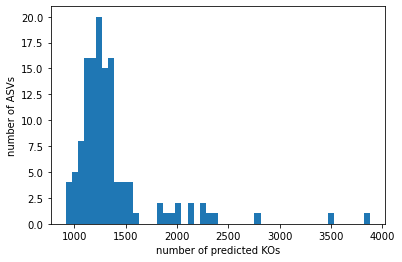

In [17]:
plt.figure()
_=plt.hist(dat.data.sum(axis=1),50)
plt.xlabel('number of predicted KOs')
plt.ylabel('number of ASVs')

### Also create a normalized version
(so we're looking at fraction of KOs instead of absolute number of KOs)

In [18]:
datn=dat.normalize(10000)

# Get the differentially abundant KO terms
## Name level

In [21]:
dd=datn.diff_abundance('dir','disease','control',random_seed=2020)

2021-05-06 17:00:31 INFO 128 samples with both values
2021-05-06 17:00:31 INFO After filtering, 3697 remain.
2021-05-06 17:00:31 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:00:34 INFO number of higher in disease: 821. number of higher in control : 663. total 1484


In [20]:
dd=dat.diff_abundance('dir','disease','control',random_seed=2020)

2021-05-06 17:00:18 INFO 128 samples with both values
2021-05-06 17:00:18 WARNING Do you forget to normalize your data? It is required before running this function
2021-05-06 17:00:18 INFO After filtering, 3697 remain.
2021-05-06 17:00:18 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:00:21 INFO number of higher in disease: 1003. number of higher in control : 77. total 1080


In [22]:
cu.splot(dd,'dir',bary_fields='level2',bary_label=False)

# Aggregate at Level2

In [23]:
d2=dat.copy()

In [24]:
d2.sparse=False

In [25]:
# d2.data[d2.data>0]=1

In [26]:
d2=d2.aggregate_by_metadata('level2',axis='f',agg='sum')
d2

Experiment with 128 samples, 38 features

### normalized version (percent of total genes)

In [27]:
d3=d2.normalize(100)

# Find KO terms (level2) different between sick and control bacteria
## Using the normalized (fraction of all genes) table

In [28]:
dd=d3.diff_abundance('dir','disease',alpha=0.1,random_seed=2020)

2021-05-06 17:01:02 INFO After filtering, 38 remain.
2021-05-06 17:01:02 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:01:03 INFO number of higher in disease: 10. number of higher in NOT disease : 14. total 24


### Normalize the effect size to -1/1

In [29]:
# normalize the effect size to be in the [-1:1] range (0 for random, -1 / 1 for fully ordered)
g1 = dd.filter_samples('dir','disease')
g2 = dd.filter_samples('dir','disease',negate=True)
n_g1 = len(g1.sample_metadata)
n_g2 = len(g2.sample_metadata)
odif = dd.feature_metadata['_calour_stat']
dd.feature_metadata['_calour_stat'] = odif / ((((n_g1 + 1) / 2) + n_g2) - ((n_g2 + 1) / 2))


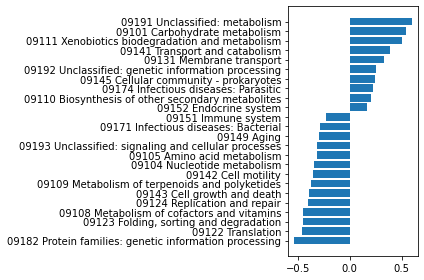

In [30]:
f=plt.figure()
plt.barh(np.arange(len(dd.feature_metadata)),dd.feature_metadata._calour_stat,tick_label=dd.feature_metadata.level2)
plt.tight_layout()
f.savefig('../figures/fig3/fig-ko-enrichment.pdf')

In [31]:
ddd=dd.normalize(1000,axis=1)

In [33]:
cu.splot(ddd,'dir',clim=[0,25])

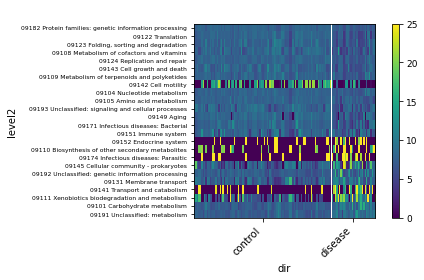

In [34]:
f=ddd.plot(sample_field='dir',clim=[0,25],feature_field='level2',yticklabel_len=None,yticklabel_kwargs={'size':6,'rotation':0})

In [35]:
f.figure.savefig('../figures/fig3/heatmap-ko2.pdf')

### No normalization

In [91]:
dd=d2.diff_abundance('dir','disease',transform='binarydata',alpha=0.1,random_seed=2020)

2020-11-11 18:37:28 WARNING Do you forget to normalize your data? It is required before running this function
2020-11-11 18:37:28 INFO After filtering, 40 remain.
2020-11-11 18:37:28 INFO 28 samples with value 1 (['disease'])
2020-11-11 18:37:28 INFO number of higher in disease: 4. number of higher in NOT disease : 0. total 4


In [92]:
cu.splot(dd,'dir')

In [93]:
dd=d2.diff_abundance('dir','disease',alpha=0.1,random_seed=2020)

2020-11-11 18:37:36 WARNING Do you forget to normalize your data? It is required before running this function
2020-11-11 18:37:36 INFO After filtering, 40 remain.
2020-11-11 18:37:36 INFO 28 samples with value 1 (['disease'])
2020-11-11 18:37:36 INFO number of higher in disease: 32. number of higher in NOT disease : 0. total 32


In [94]:
# normalize the effect size to be in the [-1:1] range (0 for random, -1 / 1 for fully ordered)
g1 = dd.filter_samples('dir','disease')
g2 = dd.filter_samples('dir','disease',negate=True)
n_g1 = len(g1.sample_metadata)
n_g2 = len(g2.sample_metadata)
odif = dd.feature_metadata['_calour_stat']
dd.feature_metadata['_calour_stat'] = odif / ((((n_g1 + 1) / 2) + n_g2) - ((n_g2 + 1) / 2))


<IPython.core.display.Javascript object>


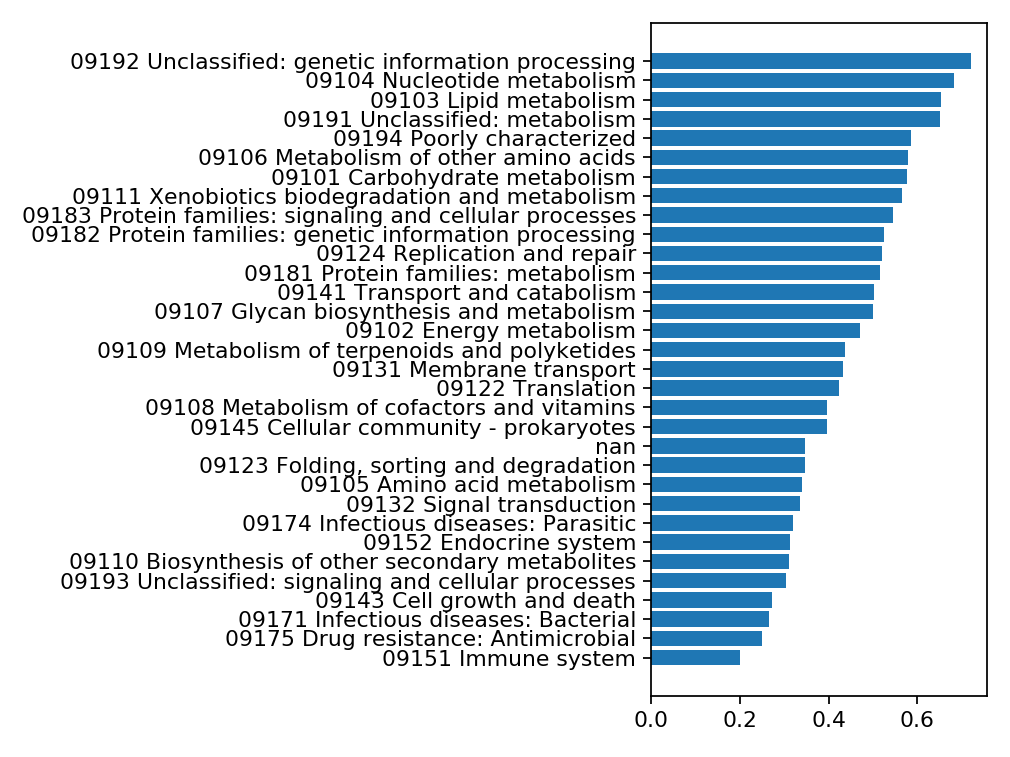

In [95]:
f=plt.figure()
plt.barh(np.arange(len(dd.feature_metadata)),dd.feature_metadata._calour_stat,tick_label=dd.feature_metadata.level2)
plt.tight_layout()
f.savefig('../figures/fig-ko-enrichment-absolute.pdf')

# Look at vitamin sub-pathways

In [46]:
rr=datn.filter_by_metadata('level2',['09108 Metabolism of cofactors and vitamins'],axis='f')


In [47]:
rrr=rr.normalize(1000,axis=1)

In [48]:
cu.splot(rrr,'dir',clim=[0,50])

In [56]:
qq=rrr.diff_abundance('dir','disease','control')

2021-05-06 17:14:42 INFO 128 samples with both values
2021-05-06 17:14:42 INFO After filtering, 176 remain.
2021-05-06 17:14:42 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:14:42 INFO number of higher in disease: 27. number of higher in control : 48. total 75


In [57]:
cu.splot(qq,'dir',clim=[0,50])

In [49]:
rr.sparse=False

In [50]:
rr3=rr.aggregate_by_metadata('level3',axis='f',agg='sum')

In [51]:
rrr3=rr3.normalize(1000,axis=1)

In [52]:
cu.splot(rrr3,'dir',clim=[0,50])

In [53]:
ddrr=rr3.diff_abundance('dir','control')

2021-05-06 17:13:43 INFO After filtering, 11 remain.
2021-05-06 17:13:43 INFO 97 samples with value 1 (['control'])
2021-05-06 17:13:44 INFO number of higher in control: 7. number of higher in NOT control : 1. total 8


In [54]:
ddrr=ddrr.normalize(1000,axis=1)

In [55]:
cu.splot(ddrr,'dir',clim=[0,50])

# Look at cellular community sub-pathways

In [43]:
rr=datn.filter_by_metadata('level2',['09171 Infectious diseases: Bacterial'],axis='f')
rr

Experiment with 128 samples, 7 features

In [44]:
rrr=rr.normalize(1000,axis=1)

In [45]:
cu.splot(rrr,'dir',clim=[0,50])

In [158]:
dd=rrr.diff_abundance('dir','disease',random_seed=2020)

2020-11-11 19:09:56 INFO After filtering, 43 remain.
2020-11-11 19:09:56 INFO 28 samples with value 1 (['disease'])
2020-11-11 19:09:56 INFO number of higher in disease: 6. number of higher in NOT disease : 0. total 6


In [104]:
cu.splot(dd,'dir',clim=[0,50])

In [159]:
# normalize the effect size to be in the [-1:1] range (0 for random, -1 / 1 for fully ordered)
g1 = dd.filter_samples('dir','disease')
g2 = dd.filter_samples('dir','disease',negate=True)
n_g1 = len(g1.sample_metadata)
n_g2 = len(g2.sample_metadata)
odif = dd.feature_metadata['_calour_stat']
dd.feature_metadata['_calour_stat'] = odif / ((((n_g1 + 1) / 2) + n_g2) - ((n_g2 + 1) / 2))


<IPython.core.display.Javascript object>


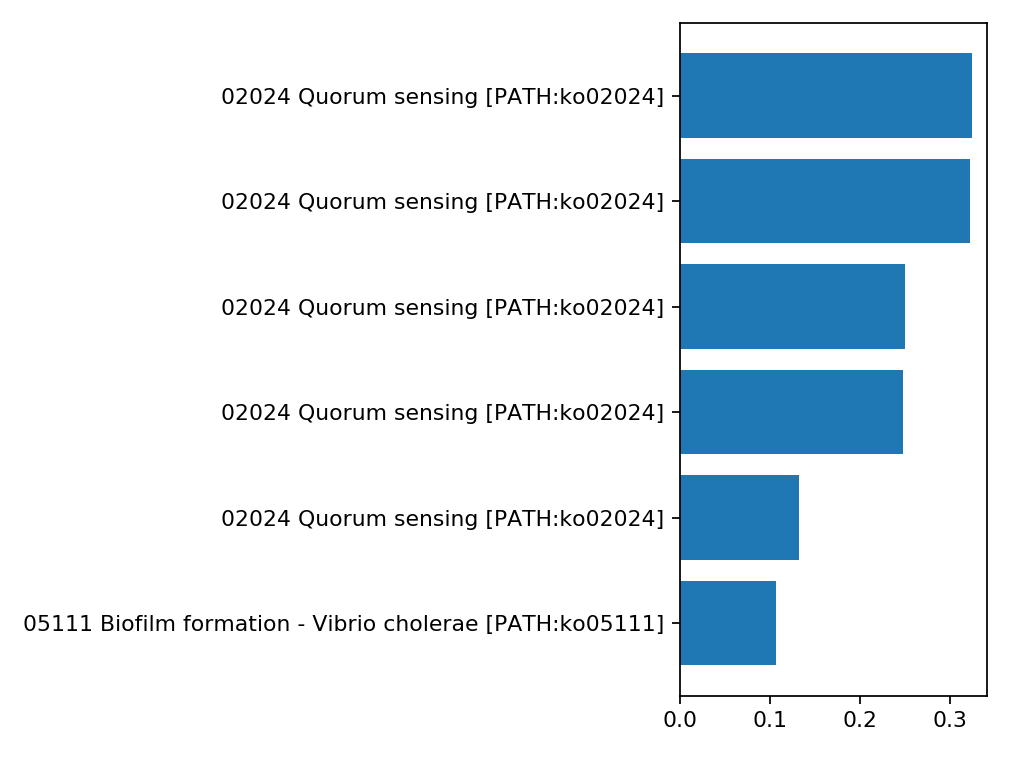

In [160]:
f=plt.figure()
labels = [x[1]['level3'] for x in dd.feature_metadata.iterrows()]
plt.barh(np.arange(len(dd.feature_metadata)),dd.feature_metadata._calour_stat,tick_label=labels)
plt.tight_layout()
f.savefig('../figures/fig3/fig-ko3-cellular-community.pdf')

# Save the per Kegg level2 term table
## with all significant names within each level2 term

In [38]:
def get_level3_sig(exp, ko, normalize=False):
    rr=exp.filter_by_metadata('level2',[ko],axis='f')
    if normalize:
        rr=rr.normalize(1000,axis=1)
    rr=rr.filter_sum_abundance(1)
    dd=rr.diff_abundance('dir','disease',random_seed=2020)
    # normalize the effect size to be in the [-1:1] range (0 for random, -1 / 1 for fully ordered)
    g1 = dd.filter_samples('dir','disease')
    g2 = dd.filter_samples('dir','disease',negate=True)
    n_g1 = len(g1.sample_metadata)
    n_g2 = len(g2.sample_metadata)
    odif = dd.feature_metadata['_calour_stat']
    dd.feature_metadata['_calour_stat'] = odif / ((((n_g1 + 1) / 2) + n_g2) - ((n_g2 + 1) / 2))

    return dd

In [39]:
dd=d3.diff_abundance('dir','disease',alpha=0.1,random_seed=2020)
for cterm in dd.feature_metadata.level2.values:
    print(cterm)
    cdd=get_level3_sig(datn,cterm)
    cdd.feature_metadata.to_csv('../picrust/pathways/'+cterm+'.txt',sep='\t')


2021-05-06 17:05:39 INFO After filtering, 38 remain.
2021-05-06 17:05:39 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:05:39 INFO number of higher in disease: 10. number of higher in NOT disease : 14. total 24
09182 Protein families: genetic information processing
2021-05-06 17:05:39 INFO After filtering, 355 remain.
2021-05-06 17:05:39 INFO After filtering, 355 remain.
2021-05-06 17:05:39 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:05:39 INFO number of higher in disease: 63. number of higher in NOT disease : 114. total 177
09122 Translation
2021-05-06 17:05:39 INFO After filtering, 87 remain.
2021-05-06 17:05:39 INFO After filtering, 87 remain.
2021-05-06 17:05:39 INFO 31 samples with value 1 (['disease'])
2021-05-06 17:05:39 INFO number of higher in disease: 5. number of higher in NOT disease : 69. total 74
09123 Folding, sorting and degradation
2021-05-06 17:05:39 INFO After filtering, 41 remain.
2021-05-06 17:05:39 INFO After filtering, 41 remain.
2021-05-06